# Pairwise analyses of simulated data

In this notebook, we explore our hypothesis that differences in tumour-specific alteration rates affect the validity of co-occurrence and mutual exclusivity tests that assume independent and identically distributed (i.i.d.) events. To this end, we first generate simulated alteration data that resemble clinical tumours, but do not contain any dependencies between alterations. Next, we add simulated co-occurrences and mutual exclusivities to these data.

Based on these simulated data sets, we assess the sensitivity and specificity of two i.i.d. tests&mdash;the Binomial test and Fisher's exact test&mdash;and our DISCOVER test.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append("../lib")

In [4]:
import numpy
import pandas

In [5]:
import nbsupport.plots
import nbsupport.simulations
import nbsupport.util

In [6]:
nbsupport.util.set_random_seed()

In [7]:
from discover.util import disableStackLimit
disableStackLimit()

## Independent alterations

We generate a simulated alteration matrix that resembles the copy number data of the TCGA breast cancer tumours. The code below requires that the TCGA data have already been downloaded (see the notebook [Download PanCan12 data](Download PanCan12 data.ipynb)).

In [8]:
dataFile = "../data/tcga/tcga-pancan12.h5"

In [9]:
cn = pandas.read_hdf(dataFile, "/data/BRCA/cn")

In [10]:
geneMarginals = (cn == 2).sum(1)
sampleMarginals = (cn == 2).sum(0)
events = pandas.DataFrame(nbsupport.simulations.generate_independent_alterations(geneMarginals, sampleMarginals))

The following plot shows that the alteration frequencies per gene (top plot) and per tumour (bottom plot) in the simulated data resemble those of the breast cancer tumours.

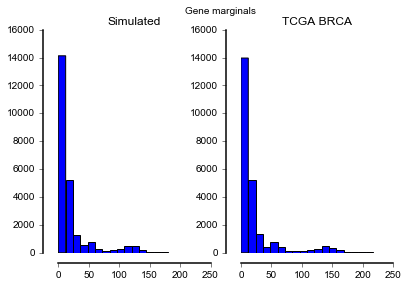

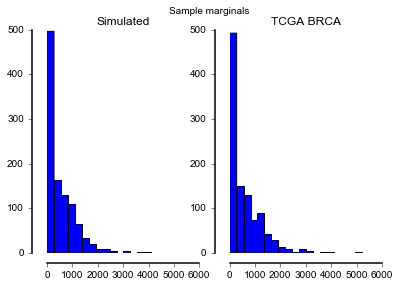

In [11]:
with nbsupport.plots.use_custom_style():
    bins = numpy.linspace(0, max(events.sum(1).max(), (cn == 2).sum(1).max()), 20)
    plt.suptitle("Gene marginals")
    plt.subplot(121)
    plt.title("Simulated")
    plt.hist(events.sum(1), bins)
    plt.subplot(122, sharex=plt.gca(), sharey=plt.gca())
    plt.title("TCGA BRCA")
    plt.hist((cn == 2).sum(1), bins)

plt.show()

with nbsupport.plots.use_custom_style():
    bins = numpy.linspace(0, max(events.sum(0).max(), (cn == 2).sum(0).max()), 20)
    plt.suptitle("Sample marginals")
    plt.subplot(121)
    plt.title("Simulated")
    plt.hist(events.sum(0), bins)
    plt.subplot(122, sharex=plt.gca(), sharey=plt.gca())
    plt.title("TCGA BRCA")
    plt.hist((cn == 2).sum(0), bins)

plt.show()

In [12]:
genesMinFreq50 = numpy.where(events.sum(1) >= 50)[0]

In [13]:
import discover

In [14]:
model0 = discover.DiscoverMatrix(pandas.DataFrame(events))

In [15]:
import numpy
def estimate_binomial_background(events):
    return numpy.repeat(events.mean(1)[:, numpy.newaxis], events.shape[1], 1)

In [16]:
modelBinom0 = discover.DiscoverMatrix(
    pandas.DataFrame(events),
    pandas.DataFrame(estimate_binomial_background(events)))

In [17]:
nullGenes1 = numpy.random.choice(genesMinFreq50, len(genesMinFreq50) / 2, False)
nullGenes2 = numpy.setdiff1d(genesMinFreq50, nullGenes1)

In [18]:
group = numpy.repeat([0, 1], [len(nullGenes1), len(nullGenes2)])

### Testing for mutual exclusivities

We first test for mutual exclusivity using the DISCOVER test.

In [19]:
result_mutex0_poisbinom = discover.pairwise_discover_test(model0[numpy.r_[nullGenes1, nullGenes2]], group)

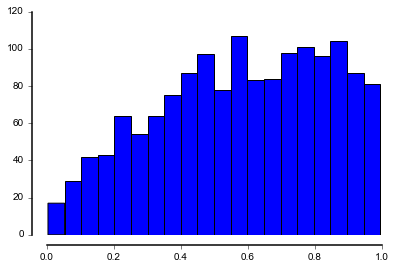

In [20]:
with nbsupport.plots.use_custom_style():
    plt.hist(numpy.diag(result_mutex0_poisbinom.pvalues.values[:len(nullGenes1), len(nullGenes1):]), 20)

And next using the Binomial test.

In [21]:
result_mutex0_binom = discover.pairwise_discover_test(modelBinom0[numpy.r_[nullGenes1, nullGenes2]], group)

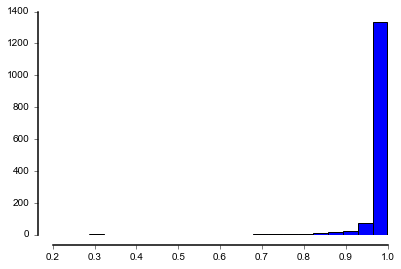

In [22]:
with nbsupport.plots.use_custom_style():
    plt.hist(numpy.diag(result_mutex0_binom.pvalues.values[:len(nullGenes1), len(nullGenes1):]), 20)

### Testing for co-occurrences

Then we test for co-occurrence using the DISCOVER test.

In [23]:
result_cooc0_poisbinom = discover.pairwise_discover_test(model0[numpy.r_[nullGenes1, nullGenes2]], group, "greater")

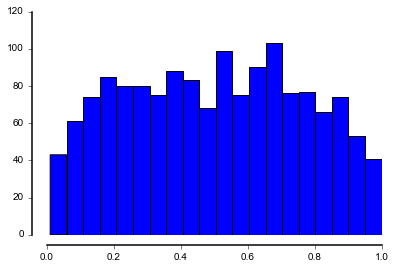

In [24]:
with nbsupport.plots.use_custom_style():
    plt.hist(numpy.diag(result_cooc0_poisbinom.pvalues.values[:len(nullGenes1), len(nullGenes1):]), 20)

And using the Binomial test.

In [25]:
result_cooc0_binom = discover.pairwise_discover_test(modelBinom0[numpy.r_[nullGenes1, nullGenes2]], group, "greater")

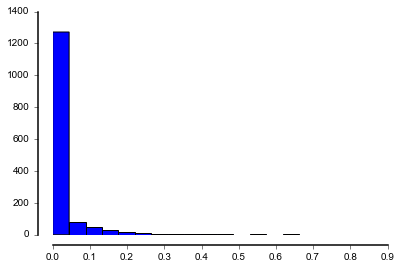

In [26]:
with nbsupport.plots.use_custom_style():
    plt.hist(numpy.diag(result_cooc0_binom.pvalues.values[:len(nullGenes1), len(nullGenes1):]), 20)

## Mutual exclusivities

Now we add simulated mutual exclusivities to the alteration matrix.

In [27]:
eventsWithMutex, indexes = nbsupport.simulations.add_mutual_exclusivities(events)

We test for mutual exclusivity using the DISCOVER test.

In [28]:
modelMutex = discover.DiscoverMatrix(pandas.DataFrame(eventsWithMutex))

In [29]:
groupMutex = numpy.repeat([0, 1], 500)

In [30]:
result_mutex_poisbinom = discover.pairwise_discover_test(modelMutex[numpy.r_[indexes[:, 0], indexes[:, 1]]], groupMutex)

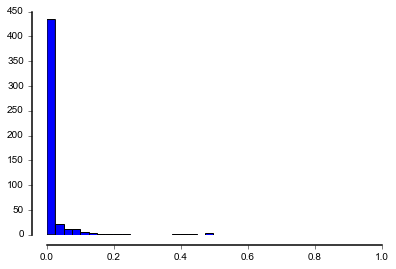

In [31]:
with nbsupport.plots.use_custom_style():
    plt.hist(numpy.diag(result_mutex_poisbinom.pvalues.values[:len(indexes), len(indexes):]), 20)
    plt.xlim(0, 1)

And using the Binomial test.

In [32]:
modelMutexBinom = discover.DiscoverMatrix(
    pandas.DataFrame(eventsWithMutex),
    pandas.DataFrame(estimate_binomial_background(eventsWithMutex)))

In [33]:
result_mutex_binom = discover.pairwise_discover_test(modelMutexBinom[numpy.r_[indexes[:, 0], indexes[:, 1]]], groupMutex)

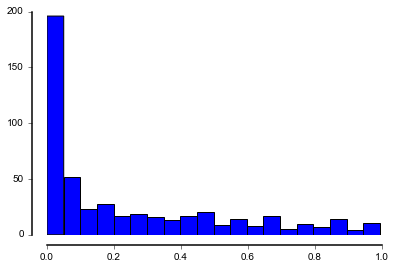

In [34]:
with nbsupport.plots.use_custom_style():
    plt.hist(numpy.diag(result_mutex_binom.pvalues.values[:len(indexes), len(indexes):]), 20)
    plt.xlim(0, 1)

## Co-occurrences

Next, we add simulated co-occurrences to the alteration matrix.

In [35]:
eventsWithCooc, coocIndexes = nbsupport.simulations.add_cooccurrences(events)

We test for co-occurrence using the DISCOVER test.

In [36]:
modelCooc = discover.DiscoverMatrix(pandas.DataFrame(eventsWithCooc))

In [37]:
groupCooc = numpy.repeat([0, 1], 500)

In [38]:
result_cooc_poisbinom = discover.pairwise_discover_test(modelCooc[numpy.r_[coocIndexes[:, 0], coocIndexes[:, 1]]], groupCooc, "greater")

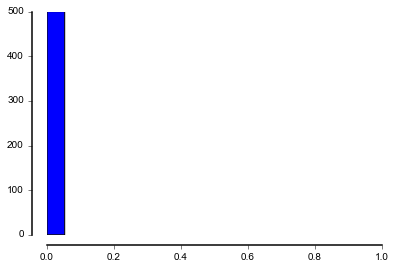

In [39]:
with nbsupport.plots.use_custom_style():
    bins = numpy.linspace(0, 1, 20)
    plt.hist(numpy.diag(result_cooc_poisbinom.pvalues.values[:len(coocIndexes), len(coocIndexes):]), bins)

And using the Binomial test.

In [40]:
modelCoocBinom = discover.DiscoverMatrix(
    pandas.DataFrame(eventsWithCooc),
    pandas.DataFrame(estimate_binomial_background(eventsWithCooc)))

In [41]:
result_cooc_binom = discover.pairwise_discover_test(modelCoocBinom[numpy.r_[coocIndexes[:, 0], coocIndexes[:, 1]]], groupCooc, "greater")

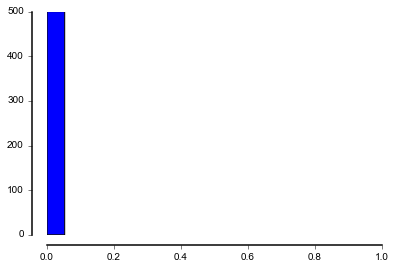

In [42]:
with nbsupport.plots.use_custom_style():
    bins = numpy.linspace(0, 1, 20)
    plt.hist(numpy.diag(result_cooc_binom.pvalues.values[:len(coocIndexes), len(coocIndexes):]), bins)

## Fisher's exact test

To illustrate that the issues observed with the Binomial test also affect Fisher's exact test, we repeat the same analyses below, this time using Fisher's exact test.

In [43]:
import scipy.stats

Testing for co-occurrence in independent alterations.

In [44]:
pCoocFisher0 = numpy.array([
        scipy.stats.fisher_exact(numpy.histogram2d(events.values[gene1], events.values[gene2], 2)[0], "greater")[1]
        for gene1, gene2 in zip(nullGenes1, nullGenes2)])

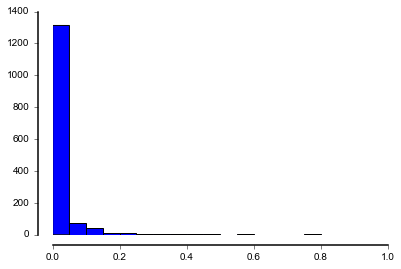

In [45]:
with nbsupport.plots.use_custom_style():
    plt.hist(pCoocFisher0, numpy.linspace(0, 1, 21))

Testing for mutual exclusivity in independent data.

In [46]:
pMutexFisher0 = numpy.array([
        scipy.stats.fisher_exact(numpy.histogram2d(events.values[gene1], events.values[gene2], 2)[0], "less")[1]
        for gene1, gene2 in zip(nullGenes1, nullGenes2)])

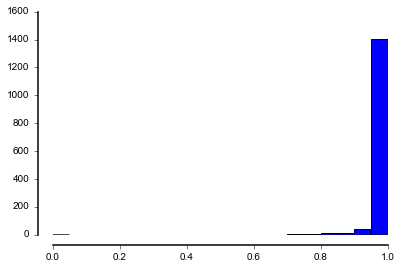

In [47]:
with nbsupport.plots.use_custom_style():
    plt.hist(pMutexFisher0, numpy.linspace(0, 1, 21))

Testing for co-occurrence in co-occurring gene pairs.

In [48]:
pCoocFisher = numpy.array([
        scipy.stats.fisher_exact(numpy.histogram2d(eventsWithCooc[gene1], eventsWithCooc[gene2], 2)[0], "greater")[1]
        for gene1, gene2 in coocIndexes])

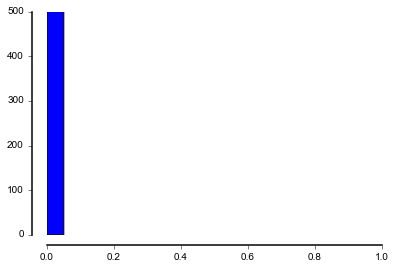

In [49]:
with nbsupport.plots.use_custom_style():
    plt.hist(pCoocFisher, numpy.linspace(0, 1, 21))

Testing for mutual exclusivity in mutually exclusive gene pairs.

In [50]:
pMutexFisher = numpy.array([
        scipy.stats.fisher_exact(numpy.histogram2d(eventsWithMutex[gene1], eventsWithMutex[gene2], 2)[0], "less")[1]
        for gene1, gene2 in indexes])

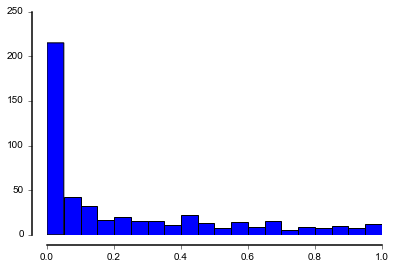

In [51]:
with nbsupport.plots.use_custom_style():
    plt.hist(pMutexFisher, numpy.linspace(0, 1, 21))

## Similar alteration rates

Finally, we show that the Binomial test does not have problems if the alteration rates per tumour are more homogeneous.

In [52]:
iidEvents = numpy.row_stack([
        numpy.random.permutation(row == 2).astype(int)
        for row in cn.values])

The following plot shows that the alteration frequences per gene still resemble those of the TCGA breast tumours. In contrast, the alteration frequencies per tumour are much more homogeneous than in the breast cancer data.

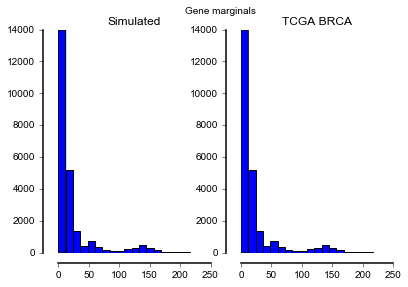

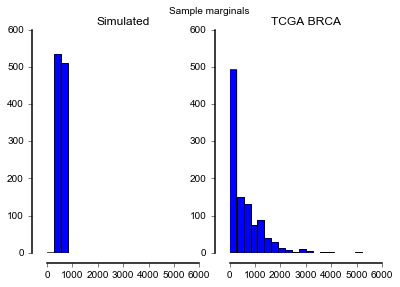

In [53]:
with nbsupport.plots.use_custom_style():
    bins = numpy.linspace(0, max(iidEvents.sum(1).max(), (cn == 2).sum(1).max()), 20)
    plt.suptitle("Gene marginals")
    plt.subplot(121)
    plt.title("Simulated")
    plt.hist(iidEvents.sum(1), bins)
    plt.subplot(122, sharex=plt.gca(), sharey=plt.gca())
    plt.title("TCGA BRCA")
    plt.hist((cn == 2).sum(1), bins)

plt.show()

with nbsupport.plots.use_custom_style():
    bins = numpy.linspace(0, max(iidEvents.sum(0).max(), (cn == 2).sum(0).max()), 20)
    plt.suptitle("Sample marginals")
    plt.subplot(121)
    plt.title("Simulated")
    plt.hist(iidEvents.sum(0), bins)
    plt.subplot(122, sharex=plt.gca(), sharey=plt.gca())
    plt.title("TCGA BRCA")
    plt.hist((cn == 2).sum(0), bins)

plt.show()

Testing for mutual exclusivity in independent data results in a much more uniform $P$-value distribution.

In [54]:
modelBinomIid0 = discover.DiscoverMatrix(
    pandas.DataFrame(iidEvents),
    pandas.DataFrame(estimate_binomial_background(iidEvents)))

In [55]:
result_iid_mutex0_binom = discover.pairwise_discover_test(modelBinomIid0[numpy.r_[nullGenes1, nullGenes2]], group)

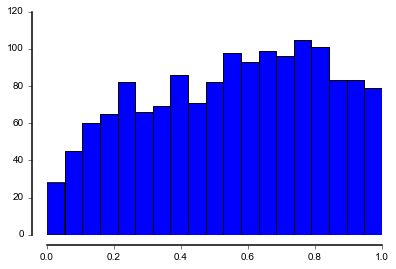

In [56]:
with nbsupport.plots.use_custom_style():
    bins = numpy.linspace(0, 1, 20)
    plt.hist(numpy.diag(result_iid_mutex0_binom.pvalues.values[:len(nullGenes1), len(nullGenes1):]), bins)

The same is true for co-occurrences.

In [57]:
result_iid_cooc0_binom = discover.pairwise_discover_test(modelBinomIid0[numpy.r_[nullGenes1, nullGenes2]], group, "greater")

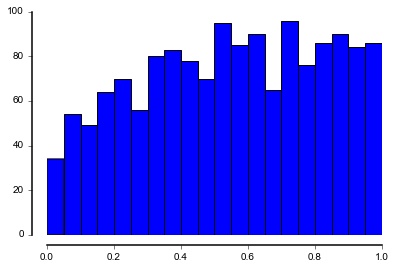

In [58]:
with nbsupport.plots.use_custom_style():
    bins = numpy.linspace(0, 1, 21)
    plt.hist(numpy.diag(result_iid_cooc0_binom.pvalues.values[:len(nullGenes1), len(nullGenes1):]), bins)